# **Physics-based loss and machine learing approach in application to fluids flow modelling**

# Initialization
## Import libraries

In [ ]:
# Pytorch modules
import torch
from torch import nn
from torch import autograd
from torchvision import transforms as T

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
from matplotlib import cm
 
# Arrays
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict

# Status bar
from tqdm.notebook import tqdm

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image, ImageOps
import cv2

# Time
from datetime import datetime
import time

## Helper functions

In [ ]:
def load_3d(ind=None, file_ex='.pt'):
    files_list = fnmatch.filter(os.listdir(DATA_DIR), f'*{file_ex}')
    print('Files list: \n')
    for i, file in enumerate(files_list):
        print(i, file)
    if ind is None:
        ind = int(input('Enter file num: '))
    if file_ex == '.pt':
        mask_tmp = torch.load(os.path.join(DATA_DIR, files_list[ind]))
    else:
        mask_tmp = Image.open(os.path.join(DATA_DIR, files_list[ind])) #open image
        mask_tmp = ImageOps.grayscale(mask_tmp).resize((SIZE, SIZE) ,resample=0)
        mask_tmp = torch.tensor(np.array(mask_tmp) == 255).float()
        mask_tmp = mask_tmp.unsqueeze(0).unsqueeze(2)
        mask_tmp = mask_tmp.repeat(1, 1, SIZE, 1)

    print('\nMask shape: ', mask_tmp.shape)
    
    size_orig = mask_tmp.shape[1]
    
    tmp_split = files_list[ind][:-3].split('_')
    
    resize = T.Resize((SIZE, SIZE), T.InterpolationMode('nearest'))

    mask = torch.zeros((1, mask_tmp.shape[1], SIZE, SIZE))

    for i in range(mask_tmp.shape[1]):
        mask[:, i] = resize(mask_tmp[:, i])

    mask_tmp = mask.clone()

    mask = torch.zeros((1, SIZE, SIZE, SIZE))

    for i in range(SIZE):
        mask[:, :, :, i] = resize(mask_tmp[:, :, :, i])

    mask_contour = torch.zeros_like(mask)
    
    mask_tmp = torch.ones(SIZE + 2, SIZE + 2, SIZE + 2)
    mask_tmp[1:-1, 1:-1, 1:-1] = mask[0]

    for i in range(SIZE):
        for j in range(SIZE):
            for k in range(SIZE):
                if mask[0, i, j, k] and mask_tmp[i:i + 3, j:j + 3, k:k + 3].sum() < 27:
                    mask_contour[0, i, j, k] = 1
    
    if SIZE == 64:
        s = 1
    elif SIZE == 128:
        s = 0.1
    elif SIZE == 256:
        s = 0.01
    else:
        s = 0.1
    
    x_scatter = np.meshgrid(np.arange(0, SIZE),
                            np.arange(0, SIZE),
                            np.arange(0, SIZE), indexing='ij')
    
    fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE * 2))
    ax = fig.add_subplot(projection='3d')
    indices = mask_contour[0].cpu().detach() == 1
    ax.scatter(x_scatter[0][indices],
               x_scatter[1][indices],
               x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    plt.title('3d mask contour')
    plt.show()
    
    fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE * 2))
    ax = fig.add_subplot(projection='3d')
    indices = mask[0].cpu().detach() == 1
    ax.scatter(x_scatter[0][indices],
               x_scatter[1][indices],
               x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    plt.title('3d mask')
    plt.show()
    
    plt.imshow(mask[0,SLICES[0],:,:])
    plt.title('mask $x_1 = const$')
    plt.colorbar()
    plt.show()
    plt.imshow(mask[0,:,SLICES[1],:])
    plt.title('mask $x_2 = const$')
    plt.colorbar()
    plt.show()
    plt.imshow(mask[0,:,:,SLICES[2]])
    plt.title('mask $x_3 = const$')
    plt.colorbar()
    plt.show()

    psi_1_init = mask[:, :, :, :].sum(1) / SIZE - 0.5
    psi_2_init = -(mask[:, :, :, :].sum(2) / SIZE - 0.5)
    psi_3_init = mask[:, :, :, :].sum(3) / SIZE - 0.5
    
    plt.imshow(psi_1_init[0])
    plt.title('psi 1 init')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_2_init[0])
    plt.title('psi 2 init')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_3_init[0])
    plt.title('psi 3 init')
    plt.colorbar()
    plt.show()
    
    psi_contour_mm = torch.zeros(3, SIZE, SIZE)
    psi_contour_pp = torch.zeros(3, SIZE, SIZE)
    
    contours, hierarchy = cv2.findContours((psi_1_init[0] > psi_1_init[0].min()).numpy().astype('uint8'),
                                               cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    psi_1_contour = cv2.drawContours(torch.zeros_like(psi_1_init[0]).numpy(), contours, -1, 1, 1)
    
    contours, hierarchy = cv2.findContours((psi_2_init[0] < psi_2_init[0].max()).numpy().astype('uint8'),
                                               cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    psi_2_contour = cv2.drawContours(torch.zeros_like(psi_1_init[0]).numpy(), contours, -1, 1, 1)
    
    for i in range(SIZE):
        psi_contour_mm[0, psi_1_contour[:, i].argmax(), i] = 1
        psi_contour_pp[0, SIZE - 1 - np.flip(psi_1_contour[:, i], 0).argmax(), i] = 1
        
        psi_contour_mm[1, psi_2_contour[:, i].argmax(), i] = 1
        psi_contour_pp[1, SIZE - 1 - np.flip(psi_2_contour[:, i], 0).argmax(), i] = 1
        
    plt.imshow(psi_contour_mm[0])
    plt.title('psi 1 contour mm')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_contour_mm[1])
    plt.title('psi 2 contour mm')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_contour_mm[2])
    plt.title('psi 3 contour mm')
    plt.colorbar()
    plt.show()
    
    plt.imshow(psi_contour_pp[0])
    plt.title('psi 1 contour pp')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_contour_pp[1])
    plt.title('psi 2 contour pp')
    plt.colorbar()
    plt.show()
    plt.imshow(psi_contour_pp[2])
    plt.title('psi 3 contour pp')
    plt.colorbar()
    plt.show()
    
    plt.imshow(mask_contour[0, :, :, 0])
    plt.title('x3[0] mask contour')
    plt.colorbar()
    plt.show()
    plt.imshow(mask_contour[0, :, :, int(SIZE // 2)])
    plt.title('x3[int(SIZE // 2)] mask contour')
    plt.colorbar()
    plt.show()
    plt.imshow(mask_contour[0, :, :, -1])
    plt.title('x3[-1] mask contour')
    plt.colorbar()
    plt.show()
    
    return (mask.to(DEVICE), mask_contour.to(DEVICE), psi_1_init, psi_2_init, psi_3_init,
            torch.stack([psi_1_init, psi_2_init, psi_3_init]).to(DEVICE),
            psi_contour_mm, psi_contour_pp)

## Сonstants for selecting inputs

In [ ]:
MASK_INDEX = 3 # Index of mask (3D: {0: pipe}, 2D: {0: Aorta, 1: Liver, 2: Parallel plates + cilynder, 3: Parallel plates})
USE_3D = False # Use or not 3D
MODEL_NAME = "MLP" # Model type (MLP or Unet)
SIZE = 128 # Number of points for each X
L = [0.016] * 3 # Domain size
FLUID_TYPE = 'non' # Fluid type (new on non)
Q_3 = 0.000004 if FLUID_TYPE == 'new' else 2.57e-06 # Flow rate
MODEL_NAME_FINAL = f'{MODEL_NAME}_{SIZE}_{L[0]}_{FLUID_TYPE}'
CALC_ERROR = True # Calculate or not errors

## Constants

In [ ]:
# Visualization
STEP3D = int(SIZE / 16) # Step for 3d visualization
SLICES = [int(SIZE/2), int(SIZE/2), int(SIZE/2)]
VPS = 10 # vector plot step 
FIGSIZE = 6 # figure size

# Load mask
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'data'
WORK_DIR = 'work'
MASK, MASK_CONTOUR, PSI_1_INIT, PSI_2_INIT, PSI_3_INIT, INP, PSI_CONTOUR_MM, PSI_CONTOUR_PP = load_3d(
    MASK_INDEX, '.pt' if USE_3D else '.png')

# Training
EPOCHS = 10000 # Number of epoches
IN_CH = 1 # number of input channels
OUT_CH = 1 # number of output channels

EARLY_STOP_PATIENCE = 2000 # number of itarations without improvement
START_WITH_SAVED = False # start training from saved best model
CONTINUE = False # continuation of training in case of interruption
DECAY = 0 # L2 regularization coef

if USE_3D:
    W_B = 100000000 # boundary loss weight
    W_V0  = 100000 # velocity on walls loss weight
    W_P = 1 # power loss weight
else:
    W_B = 0 if MODEL_NAME == 'Unet' else 100000 # boundary loss weight
    W_V0  = 10 if MODEL_NAME == 'Unet' else 1 # velocity on walls loss weight
    W_P = 1 if MODEL_NAME == 'Unet' else 2 # power loss weight

USE_MASK = 1 if MODEL_NAME == 'MLP' else 0 # 0 - withot mask for power loss 1 - mask for flow area 2 - mask for flow area and walls
USE_TORCH_INTEGRAL = False # integral solution type
DIFF_AUTO = True # enable auto differentiation (only for MLP)
USE_SINGLE_BOUNDARY = True if MODEL_NAME == 'MLP' else False # use psipp and psimm only for boundary between fluid and walls

LOG_PARAMETERS = {'START_WITH_SAVED': START_WITH_SAVED,
                  'SIZE': SIZE,
                  'EPOCHS': EPOCHS,
                  'MODEL_NAME': MODEL_NAME,
                  'W_B': W_B,
                  'W_V0': W_V0,
                  'USE_MASK': USE_MASK,
                  'USE_TORCH_INTEGRAL': USE_TORCH_INTEGRAL,
                  'DIFF_AUTO': DIFF_AUTO,
                  'USE_SINGLE_BOUNDARY': USE_SINGLE_BOUNDARY}

HYPS = []

if MODEL_NAME == 'Unet':
    hyps = {"learning_rate": [1e-3],
            "optimizer": ['adam'],
            "scheduler": ["step"],
            "scheduler_factor": [0.1],
            "scheduler_patience": [5000],
            "use_bn": [True],
            "num_of_feat": [32],
            'use_sigmoid': [True]}
else:
    hyps = {"learning_rate": [1e-3],
            "optimizer": ['adam'],
            "scheduler": ["step"],
            "hidden_neurons": [20],
            "hidden_layers": [10],
            "scheduler_factor": [0.1],
            "scheduler_patience": [5000],
            'use_sigmoid': [False]}
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})

## Geometry of the flow domain, fluid properties and boundary conditions

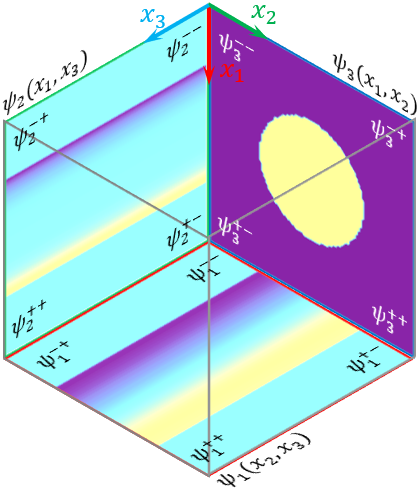

Geometry

It is convenient to present the flow domain $\Omega$ in the form of a parallelepiped $x_i^- < x_i < x_i^+$ ($\boldsymbol{L} = [l_i] = [x_i^+ - x_i^-]$, $i = 1,2,3$).

In [ ]:
# L_1 x L_2 x L_3 flow domain

# Normalized coordinates, normalized finite diferences, limits and elementary volume
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)
X3N = torch.linspace(0, 1, SIZE)

X1_1, X1_2 = torch.meshgrid([X2N, X3N], indexing='ij')
X2_1, X2_2 = torch.meshgrid([X1N, X3N], indexing='ij')
X3_1, X3_2 = torch.meshgrid([X1N, X2N], indexing='ij')

DX1N = (X1N[1] - X1N[0]).to(DEVICE)
DX2N = (X2N[1] - X2N[0]).to(DEVICE)
DX3N = (X3N[1] - X3N[0]).to(DEVICE)

LIM1 = [0, L[0]]
LIM2 = [0, L[1]]
LIM3 = [0, L[2]]

D_OMEGA = (DX1N * DX2N * DX3N * L[0] * L[1] * L[2]).to(DEVICE) # elementary volume

Boundary conditions
1. The values of the flow rates $Q_i(x_i^-)$, $Q_i(x_i^+)$ through the edges $x_i = x_i^-$, $x_i = x_i^+$ of the flow domain are given:

In [ ]:
#Flow rates Q1-,Q2-,Q3-
QM = [0, 0, -Q_3]

#Flow rates Q1+,Q2+,Q3+
QP = [0, 0, Q_3]

2. NL layers have fixed values of the unknown function $\boldsymbol\Psi$.

In [ ]:
DVTEMP = 'sc' # template for the velocity function differentiation

if  DVTEMP == 'sc':
    NL = 3 + 5
elif DVTEMP == 'fc':
    NL = 5 + 5

$\boldsymbol\Psi$ on borders

In [ ]:
if USE_3D:
    PSIMM = torch.tensor([0, 0, 0]).float()
    PSIPP = torch.tensor([QP[2] / (2 * L[1] - L[0]), 2 * QP[2] / (2 * L[1] - L[0]), 0]).float()
    # similar to analytical solution for a pipe
    PSI_NORM = PSIPP.reshape(3, 1, 1, 1).to(DEVICE)
else:
    PSIMM = torch.tensor([0, 0, 0]).float()
    PSIPP = torch.tensor([0, QP[2] / L[1], 0]).float()
    # similar to analytical solution for a pipe
    PSI_NORM = PSIPP.reshape(3, 1, 1, 1).to(DEVICE)

Properties of non-Newtonian fluid and walls that are relatively rigid body.
The Herschel-Bulkley law is applied:
\begin{equation}
    \mu(H)=q_0+q_1H^{z-1},
\end{equation}
where $q_0$, $q_1$, $z$ are the parameters obtained from rheological tests.

In [ ]:
#Non-Newtonian fluid viscosity
if FLUID_TYPE == 'new':
    Q0 = 4e-3
    Q1 = 0
    Z = 1
else:
    Q0 = 0
    Q1 = 0.0132
    Z = 0.801
# Fluid density, kg/m**3
RHO = 1000
#Newtonian fluid analogue
MU = Q0

#Critical Reynolds number
Re_cr = 1100

#Walls viscosity
Q0W = 1e+0#1e-0#1e+3eye 
Q1W = 0#1e-0
ZW =1#0.5

# Additional functions
## 3D numerical derivative

In [ ]:
def num_diff(f,dx1,dx2,dx3,template='sc'):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2,
    k - index along x_3.
    '''
    #Shape
    n1, n2, n3 = f.shape
    
    df_dx1, df_dx2, df_dx3 = torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3), torch.zeros(n1, n2, n3)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        df_dx3 = df_dx3.to('cuda')
    
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:,:] = (f[2:,:,:] - f[:-2,:,:]) / (2 * dx1)
        df_dx1[0,:,:] = (-f[2,:,:] + 4 * f[1,:,:] - 3 * f[0,:,:]) / (2 * dx1)
        df_dx1[n1-1,:,:] = (3 * f[n1-1,:,:] - 4 * f[n1-2,:,:] + f[n1-3,:,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1, :] = (f[:, 2:, :] - f[:, :-2, :]) / (2 * dx2)
        df_dx2[:,0, :] = (- f[:,2,:] + 4 * f[:,1,:] - 3 * f[:, 0, :]) / (2 * dx2)
        df_dx2[:,n2-1, :] = (3 * f[:, n2 - 1, :] - 4 * f[:, n2 - 2, :] + f[:, n2 - 3, :]) / (2 * dx2)
        # x3 derivative:
        df_dx3[:, :, 1:n3-1] = (f[:,:,2:] - f[:,:,:-2]) / (2 * dx3)
        df_dx3[:, :, 0] = (- f[:, :, 2] + 4 * f[:, :, 1] - 3 * f[:, :, 0]) / (2 * dx3)
        df_dx3[:, :, n3-1] = (3 * f[:, :, n3 - 1] - 4 * f[:, :, n3 - 2] + f[:, :, n3 - 3]) / (2 * dx3)
    elif template == 'fc':
        # x1 derivative
        df_dx1[2:n1-2, :, :] = (-f[4:, :,:] + 8 * f[3:n1-1, :, :] - 8 * f[1:n1-3, :, :] + f[:n1-4, :, :]) / (12 * dx1)
        df_dx1[0, :, :] = (-3 * f[4, :, :] + 16 * f[3, :, :] - 36 * f[2, :, :] + 48 * f[1, :,:] - 25 * f[0, :, :]) / (12 * dx1)
        df_dx1[1, :, :] = (f[4, :, :] - 6 * f[3, :, :] + 18 * f[2, :, :] - 10 * f[1, :, :] - 3 * f[0, :, :]) / (12 * dx1)
        df_dx1[n1-2, :, :] = (3 * f[n1-1, :, :] + 10 * f[n1-2, :, :] - 18 * f[n1-3, :, :] + 6 * f[n1-4, :, :] - f[n1-5, :, :]) / (12 * dx1)
        df_dx1[n1-1, :, :] = (25 * f[n1-1, :, :] - 48 * f[n1-2, :, :] + 36 * f[n1-3, :, :] - 16 * f[n1-4, :, :] + 3*f[n1-5, :, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2, :] = (-f[:, 4:, :] + 8 * f[:, 3:n2-1, :] - 8 * f[:, 1:n2-3, :] + f[:, :n2-4, :]) / (12 * dx2)
        df_dx2[:, 0, :] = (-3 * f[:,4, :] + 16 * f[:, 3, :] - 36 * f[:, 2, :] + 48 * f[:, 1, :] - 25 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, 1, :] = (f[:, 4, :] - 6 * f[:, 3, :] + 18 * f[:, 2, :] - 10 * f[:, 1, :] - 3 * f[:, 0, :]) / (12*dx2)
        df_dx2[:, n2-2, :] = (3 * f[:, n2-1, :] + 10 * f[:, n2-2, :] - 18 * f[:, n2-3, :] + 6 * f[:, n2-4, :] - f[:, n2-5, :]) / (12*dx2)
        df_dx2[:, n2-1, :] = (25 * f[:, n2-1, :] - 48 * f[:, n2-2, :] + 36 * f[:, n2-3, :] - 16 * f[:, n2-4, :] + 3 * f[:,n2-5, :]) / (12*dx2)       
        # x3 derivative
        df_dx3[:, :, 2:n3-2] = (-f[:, :, 4:] + 8 * f[:, :, 3:n3-1] - 8 * f[:, :, 1:n3-3] + f[:, :, :n3-4]) / (12 * dx3)
        df_dx3[:, :, 0] = (-3 * f[:, :, 4] + 16 * f[:, :, 3] - 36 * f[:, :, 2] + 48 * f[:, :, 1] - 25 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, 1] = (f[:, :, 4] - 6 * f[:, :, 3] + 18 * f[:, :, 2] - 10 * f[:, :, 1] - 3 * f[:, :, 0]) / (12 * dx3)
        df_dx3[:, :, n3-2] = (3 * f[:, :, n3-1] + 10 * f[:, :, n3-2] - 18 * f[:, :, n3-3] + 6 * f[:,:,n3-4] - f[:, :, n3-5]) / (12 * dx3)
        df_dx3[:, :, n3-1] = (25 * f[:,:, n3-1] - 48 * f[:,:, n3-2] + 36 * f[:,:, n3-3] - 16 * f[:,:, n3-4] + 3*f[:,:, n3-5]) / (12 * dx3)
    
    return df_dx1, df_dx2, df_dx3

## 2D numerical derivative

In [ ]:
def num_diff2D(f,dx1,dx2,template=DVTEMP):
    '''The following templates are applied:
    sc - second-order central difference,
    fc - fifth-order central difference.
    Indexing:
    i - index along x_1,
    j - index along x_2.
    '''
    #Shape
    n1, n2 = f.shape
    
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    
    #Device
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
            
    #Derivatives
    if template == 'sc':
        # x1 derivative:
        df_dx1[1:n1-1,:] = (f[2:,:] - f[:-2,:]) / (2 * dx1)
        df_dx1[0,:] = (-f[2,:] + 4 * f[1,:] - 3 * f[0,:]) / (2 * dx1)
        df_dx1[n1-1,:] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx1)
        # x2 derivative:
        df_dx2[:,1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx2)
        df_dx2[:,0] = (- f[:,2] + 4 * f[:,1] - 3 * f[:, 0]) / (2 * dx2)
        df_dx2[:,n2-1] = (3 * f[:, n2 - 1] - 4 * f[:, n2 - 2] + f[:, n2 - 3]) / (2 * dx2)
    elif template == 'fc':
        # 1st order x1 derivative:
        # x1 derivative
        df_dx1[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx1)
        df_dx1[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx1)
        df_dx1[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx1)
        df_dx1[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx1)
        df_dx1[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx1)
        
        # x2 derivative
        df_dx2[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx2)
        df_dx2[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:, 0]) / (12*dx2)
        df_dx2[:, 1] = (f[:, 4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:, 0]) / (12*dx2)
        df_dx2[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:, n2-5]) / (12*dx2)
        df_dx2[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx2)    
    
    return df_dx1, df_dx2

## 3D auto derivative
# !!! not implement

In [ ]:
def diff_auto_3d(f, x1, x2, x3):
    df_dx1 = autograd.grad(f.sum(), x1[0], create_graph=True)[0]
    if len(x1) == 2:
        df_dx1 += autograd.grad(f.sum(), x1[1], create_graph=True)[0]
    df_dx2 = autograd.grad(f.sum(), x2[0], create_graph=True)[0]
    if len(x2) == 2:
        df_dx2 += autograd.grad(f.sum(), x2[1], create_graph=True)[0]
    df_dx3 = autograd.grad(f.sum(), x3[0], create_graph=True)[0]
    if len(x3) == 2:
        df_dx3 += autograd.grad(f.sum(), x3[1], create_graph=True)[0]
    return df_dx1.reshape(SIZE, SIZE), df_dx2.reshape(SIZE, SIZE), df_dx3.reshape(SIZE, SIZE)

## 2D auto derivative

In [ ]:
def diff_auto(f, x1, x2):
    df_dx1 = autograd.grad(f.sum(), x1, create_graph=True)[0]
    df_dx2 = autograd.grad(f.sum(), x2, create_graph=True)[0]
    return df_dx1.reshape(SIZE, SIZE), df_dx2.reshape(SIZE, SIZE)

## 3D numerical integration (Simpson method)

In [ ]:
def int_func_simpson_3d(f, dx, dy, dz):
    '''
    f - 3d-dimentional tensor
    dx, dy, dz - constant step along the corresponding coordinate
    '''
    n1,n2,n3 = f.shape
    # integrate by dz:
    if n3%2 == 0:
        J3 = (f[:,:,0:n3-2:2] + 4*f[:,:,1:n3-2:2] + f[:,:,2::2]).sum(dim=2)*dz/3 + (f[:,:,-1]+f[:,:,-2])*dz/2
    else:
        J3 = (f[:,:,0:n3-1:2] + 4*f[:,:,1:n3-1:2] + f[:,:,2::2]).sum(dim=2)*dz/3

    # integrate by dy:
    if n2%2 == 0:
        J2 = (J3[:,0:n2-2:2] + 4*J3[:,1:n2-2:2] + J3[:,2::2]).sum(dim=1)*dy/3 + (J3[:,-1]+J3[:,-2])*dy/2
    else:
        J2 = (J3[:,0:n2-1:2] +4 *J3[:,1:n2-1:2] + J3[:,2::2]).sum(dim=1)*dy/3

    # integrate by dx:
    if n1%2 == 0:
        J1 = (J2[0:n1-2:2] + 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
    else:
        J1 = (J2[0:n1-1:2] + 4*J2[1:n1-1:2] + J2[2::2]).sum(dim=0)*dx/3

    return J1

## 2D numerical integration (Simpson method)

In [ ]:
def int_func_simpson_2d(f, dx, dy):
    '''
    f - 2d-dimentional tensor
    dx, dy - constant step along the corresponding coordinate
    '''
    n1, n2 = f.shape
    # integrate by dy:
    if n2%2 == 0:
        J2 = (f[:,0:n2-2:2]+ 4*f[:,1:n2-2:2] + f[:,2::2]).sum(dim=1)*dy/3 + (f[:,-1]+f[:,-2])*dy/2
    else:
        J2 = (f[:,0:n2-1:2] +4*f[:,1:n2-1:2]+f[:,2::2]).sum(dim=1)*dy/3
    # integrate by dx:
    if n1%2 == 0:
        J1 = (J2[0:n1-2:2]+ 4*J2[1:n1-2:2] + J2[2::2]).sum(dim=0)*dx/3 + (J2[-1]+J2[-2])*dx/2
    else:
        J1 = (J2[0:n1-1:2] +4*J2[1:n1-1:2]+J2[2::2]).sum(dim=0)*dx/3
    return J1

# Visualization functions

In [ ]:
def vector_plot(x, y, u, v, gradmag, FIGSIZE, vptitle='vector_plot', xlabel='$x_i$', ylabel='$x_j$',step=10):
    
    plt.pcolor(x, y, gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(x[::step,::step], y[::step,::step], u[::step,::step], v[::step,::step])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(vptitle)
    
    
def vector_plot_3d(x, v, v_abs, figSize=FIGSIZE, step=1, use_color=False, use_full_mask=False):
    fig = plt.figure(figsize=(figSize, figSize))
    ax = fig.add_subplot(projection='3d')
    if SIZE == 64:
        s = 1
    elif SIZE == 128:
        s = 0.1
    elif SIZE == 256:
        s = 0.01
    else:
        s = 0.1
    norm = plt.Normalize()
    colors = plt.cm.jet(norm(v_abs[::step, ::step, ::step]))
    
    x_scatter = np.meshgrid(np.arange(0, SIZE),
                            np.arange(0, SIZE),
                            np.arange(0, SIZE), indexing='ij')
    
    if use_full_mask:
        indices = MASK[0].cpu().detach() == 1
        ax.scatter(x_scatter[0][indices],
                   x_scatter[1][indices],
                   x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
    else:
        indices = MASK_CONTOUR[0].cpu().detach() == 1
        ax.scatter(x_scatter[0][indices],
                   x_scatter[1][indices],
                   x_scatter[2][indices], c='red', s=s * 50, alpha=0.2)
        
    ax.quiver(x[0], x[1], x[2], v[::step, ::step, ::step, 0],
              v[::step, ::step, ::step, 1],
              v[::step, ::step, ::step, 2],
              color=colors.reshape(-1, 4) if use_color else 'b', length=10)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'$x_1$')
    ax.set_ylabel(f'$x_2$')
    ax.set_zlabel(f'$x_3$')
    ax.bar3d(0, 0, 0., SIZE, SIZE, SIZE, alpha=0.1, edgecolor='black', color='black')
    plt.show()
    
    
def flowVisualization(psi, v1, v2, v3, v_abs, step=15,slices=SLICES, use_mask=False):
    nr=2
    nc=3
    
    if use_mask:
        psi[0, 0, PSI_1_INIT[0] == PSI_1_INIT[0].min()] = 0
        psi[0, 1, PSI_2_INIT[0] == PSI_2_INIT[0].max()] = 0
        psi[0, 2, PSI_3_INIT[0] == 0] = 0
    #Velocity distribution
    v = torch.stack([v1, v2, v3])
    
    indices = [1, 2, 0, 2, 0, 1]
    
    print('Psi function Visualization')
    fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    for i in range(3):
        plt.subplot(nr,nc,i+1)
        plt.imshow(psi[0,i,::], extent=(0, L[indices[i * nr + 1]], L[indices[i * nr ]], 0), aspect='auto')
        plt.ylabel(f'$x_{indices[i * nr] + 1}$')
        plt.xlabel(f'$x_{indices[i * nr + 1] + 1}$')
        plt.title(f'$\psi_{i+1}$')
        plt.subplot(nr,nc,i+1+nc)
        plt.plot(X2N * L[1] if not i else X1N * L[0], psi[0,i,:,slices[i]])
        plt.title(f'$x_{indices[i * nr + 1] + 1} = const$')
        plt.xlabel(f'$x_{indices[i * nr] + 1}$')
        plt.ylabel(f'$\psi_{i+1}$')
        plt.grid()
    plt.show()
    
    
    fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*1))
    for i in range(3):
        plt.subplot(1,nc,i+1)
        plt.plot(X2N * L[1] if i == 2 else X3N * L[0], torch.ones(SIZE) * PSIMM[i])
        plt.plot(X2N * L[1] if i == 2 else X3N * L[0], torch.ones(SIZE) * PSIPP[i])
        if i < 2:
            plt.plot(X2N * L[1] if i == 2 else X3N * L[0], psi[0,i,PSI_CONTOUR_MM[i] == 1])
            plt.plot(X2N * L[1] if i == 2 else X3N * L[0], psi[0,i,PSI_CONTOUR_PP[i] == 1])
        plt.title(f'Boundary $\psi_{i + 1}$')
        plt.xlabel(f'$x_{indices[i * nr + 1] + 1}$')
        plt.ylabel(f'$\psi_{i+1}$')
        plt.legend(['$\psi_m$ gt', '$\psi_p$ gt', '$\psi_m$ pred', '$\psi_p$ pred'])
        plt.grid()
    plt.show()

    psi1_mm = psi[0, 0, PSI_CONTOUR_MM[0, :, 0].argmax(), 0]
    psi1_pm = psi[0, 0, PSI_CONTOUR_PP[0, :, 0].argmax(), 0]
    psi1_mp = psi[0, 0, PSI_CONTOUR_MM[0, :, -1].argmax(), -1]
    psi1_pp = psi[0, 0, PSI_CONTOUR_PP[0, :, -1].argmax(), -1]
    
    psi2_mm = psi[0, 1, PSI_CONTOUR_MM[1, :, 0].argmax(), 0]
    psi2_pm = psi[0, 1, PSI_CONTOUR_PP[1, :, 0].argmax(), 0]
    psi2_mp = psi[0, 1, PSI_CONTOUR_MM[1, :, -1].argmax(), -1]
    psi2_pp = psi[0, 1, PSI_CONTOUR_PP[1, :, -1].argmax(), -1]

    psi3_mm = psi[0, 2, PSI_CONTOUR_MM[2, :, 0].argmax(), 0]
    psi3_pm = psi[0, 2, PSI_CONTOUR_PP[2, :, 0].argmax(), 0]
    psi3_mp = psi[0, 2, PSI_CONTOUR_MM[2, :, -1].argmax(), -1]
    psi3_pp = psi[0, 2, PSI_CONTOUR_PP[2, :, -1].argmax(), -1]


    print(f'Q1+ = {- (psi2_pp - psi2_pm) * L[1] + (psi3_pp - psi3_pm) * L[2]}, target value: {QP[0]},')
    print(f'Q2+ = {- (psi3_pp - psi3_mp) * L[2] + (psi1_pp - psi1_pm) * L[0]}, target value: {QP[1]},')
    print(f'Q3+ = {- (psi1_pp - psi1_mp) * L[0] + (psi2_pp - psi2_mp) * L[1]}, target value: {QP[2]}')
    
#     print(f'Q1+ = {- (psi[0,1,-1,-1] - psi[0,1,-1,0]) * L[1] + (psi[0,2,-1,-1]
#                    - psi[0,2,-1,0]) * L[2]}, target value: {QP[0]},')
#     print(f'Q2+ = {- (psi[0,2,-1,-1] - psi[0,2,0,-1]) * L[2] + (psi[0,0,-1,-1]
#                    - psi[0,0,-1,0]) * L[0]}, target value: {QP[1]},')
#     print(f'Q3+ = {- (psi[0,0,-1,-1] - psi[0,0,0,-1]) * L[0] + (psi[0,1,-1,-1]
#                    - psi[0,1,0,-1]) * L[1]}, target value: {QP[2]}')
    
    print()
    print('Velocity distribution visualization without flow domain mask (first line) and with mask (second line)')

    XN = torch.meshgrid(X1N * L[0], X2N * L[1], X3N * L[2], indexing='ij')
    
    fig1 = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
    #without flow domain mask 
    plt.subplot(nr,nc,1)
    vector_plot(XN[2][slices[0],:,:], XN[1][slices[0],:,:], v[2,slices[0],:,:] / L[2], v[1,slices[0],:,:] / L[1],
                np.sqrt(v[2,slices[0],:,:]**2 + v[1,slices[0],:,:]**2),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,2)
    vector_plot(XN[2][:,slices[1],:], XN[0][:,slices[1],:], v[2,:,slices[1],:] / L[2], v[0,:,slices[1],:] / L[0],
                np.sqrt(v[2,:,slices[1],:]**2 + v[0,:,slices[1],:]**2),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,3)
    vector_plot(XN[1][:,:,slices[2]], XN[0][:,:,slices[2]], v[1,:,:,slices[2]] / L[1], v[0,:,:,slices[2]] / L[0],
                np.sqrt(v[1,:,:,slices[2]]**2 + v[0,:,:,slices[2]]**2),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    #with flow domain mask 
    plt.subplot(nr,nc,4)
    vector_plot(XN[2][0,:,:], XN[1][0,:,:], v[2,slices[0],:,:] * MASK[0,slices[0],:,:].to('cpu') / L[2],
                v[1,slices[0],:,:] * MASK[0,slices[0],:,:].to('cpu') / L[1],
                np.sqrt(v[2,slices[0],:,:]**2 + v[1,slices[0],:,:]**2) * MASK[0,slices[0],:,:].to('cpu'),
                FIGSIZE, vptitle='$x_1 = const$', xlabel='$x_3$', ylabel='$x_2$', step=step)
    plt.subplot(nr,nc,5)
    vector_plot(XN[2][:,0,:], XN[0][:,0,:], v[2,:,slices[1],:] * MASK[0,:,slices[1],:].to('cpu') / L[2],
                v[0,:,slices[1],:] * MASK[0,:,slices[1],:].to('cpu') / L[0],
                np.sqrt(v[2,:,slices[1],:]**2 + v[0,:,slices[1],:]**2) * MASK[0,:,slices[1],:].to('cpu'),
                FIGSIZE, vptitle='$x_2 = const$', xlabel='$x_3$', ylabel='$x_1$', step=step)
    plt.subplot(nr,nc,6)
    vector_plot(XN[1][:,:,0], XN[0][:,:,0], v[1,:,:,slices[2]] * MASK[0,:,:,slices[2]].to('cpu') / L[1],
                v[0,:,:,slices[2]] * MASK[0,:,:,slices[2]].to('cpu') / L[0],
                np.sqrt(v[1,:,:,slices[2]]**2 + v[0,:,:,slices[2]]**2) * MASK[0,:,:,slices[2]].to('cpu'),
                FIGSIZE, vptitle='$x_3 = const$', xlabel='$x_2$', ylabel='$x_1$', step=step)
    plt.show()
    
    #Check the flow rates Q3-,Q3+
    Q1mch = int_func_simpson_2d((v * MASK[0].cpu())[0, 0, :, :], L[1] * DX2N.to('cpu'), L[2] * DX3N.to('cpu'))
    Q1pch = int_func_simpson_2d((v * MASK[0].cpu())[0,-1, :, :], L[1] * DX2N.to('cpu'), L[2] * DX3N.to('cpu'))
    
    Q2mch = int_func_simpson_2d((v * MASK[0].cpu())[1, :, 0, :], L[0] * DX1N.to('cpu'), L[2] * DX3N.to('cpu'))
    Q2pch = int_func_simpson_2d((v * MASK[0].cpu())[1, :,-1, :], L[0] * DX1N.to('cpu'), L[2] * DX3N.to('cpu'))
    
    Q3mch = int_func_simpson_2d((v * MASK[0].cpu())[2, :, :, 0], L[0] * DX1N.to('cpu'), L[1] * DX2N.to('cpu'))
    Q3pch = int_func_simpson_2d((v * MASK[0].cpu())[2, :, :,-1], L[0] * DX1N.to('cpu'), L[1] * DX2N.to('cpu'))
    
    print(f'{v[0].min()} < v_1 < {v[0].max()},')
    print(f'{v[1].min()} < v_2 < {v[1].max()},')
    print(f'{v[2].min()} < v_3 < {v[2].max()},')
    print(f'Q1- = {Q1mch}, Q1+ = {Q1pch}')
    print(f'Q2- = {Q2mch}, Q2+ = {Q2pch}')
    print(f'Q3- = {Q3mch}, Q3+ = {Q3pch}')
    
    print(f'v_abs[0,0,0] = {v_abs[0,0,0]}, v_abs[0,0,-1] = {v_abs[0,0,-1]}, v_abs[0,-1,0] = {v_abs[0,-1,0]}, v_abs[0,-1,-1] = {v_abs[0,-1,-1]}, v_abs[-1,0,0] = {v_abs[-1,0,0]}, v_abs[-1,0,-1] = {v_abs[-1,0,-1]}, v_abs[-1,-1,0] = {v_abs[-1,-1,0]}, v_abs[-1,-1,-1] = {v_abs[-1,-1,-1]},')
    
    print()
    print('Boundary velocity check')
    
    plt.figure(figsize=(FIGSIZE, FIGSIZE))
    plt.title('${v_{abs}}$ on boundary')
    plt.boxplot(v_abs[MASK_CONTOUR[0].cpu() == 1].cpu().detach().numpy(), labels=['${v_{abs}}$'])
    plt.show()
  
    return


def v_contours_and_slices(v, ind):
    fig = plt.figure(figsize=(FIGSIZE * 3, FIGSIZE * 3))

    plt.subplot(3,3,1)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1=const,x_2,x_3)$')
    plt.imshow(v[SLICES[0],:,:], extent=(0, L[2], L[1], 0), aspect='auto')
    plt.ylabel('$x_2$')
    plt.xlabel('$x_3$')
    plt.colorbar()

    plt.subplot(3,3,2)
    plt.plot(X3N * L[2], v[SLICES[0],SLICES[1],:])
    plt.title(f'$(x_1=const,x_2=const,x_3)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_3$')
    plt.grid()

    plt.subplot(3,3,3)
    plt.plot(X2N * L[1], v[SLICES[0],:,SLICES[2]])
    plt.title(f'$(x_1=const,x_2,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_2$')
    plt.grid()


    plt.subplot(3,3,4)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2=const,x_3)$')
    plt.imshow(v[:,SLICES[1],:], extent=(0, L[2], L[0], 0), aspect='auto')
    plt.ylabel('$x_1$')
    plt.xlabel('$x_3$')
    plt.colorbar()

    plt.subplot(3,3,5)
    plt.plot(X3N * L[2], v[SLICES[0],SLICES[1],:])
    plt.title(f'$(x_1=const,x_2=const,x_3)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_3$')
    plt.grid()

    plt.subplot(3,3,6)
    plt.plot(X1N * L[0], v[:,SLICES[1],SLICES[2]])
    plt.title(f'$(x_1,x_2=const,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_1$')
    plt.grid()


    plt.subplot(3,3,7)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2,x_3=const)$')
    plt.imshow(v[:,:,SLICES[2]], extent=(0, L[1], L[0], 0), aspect='auto')
    plt.ylabel('$x_1$')
    plt.xlabel('$x_2$')
    plt.colorbar()

    plt.subplot(3,3,8)
    plt.plot(X2N * L[1], v[SLICES[0],:,SLICES[2]])
    plt.title(f'$(x_1=const,x_2,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_2$')
    plt.grid()

    plt.subplot(3,3,9)
    plt.plot(X1N * L[0], v[:,SLICES[1],SLICES[2]])
    plt.title(f'$(x_1,x_2=const,x_3=const)$')
    plt.ylabel('$v_{' + str(ind) + '}$')
    plt.xlabel('$x_1$')
    plt.grid()
    plt.subplots_adjust(wspace=0.35)
    plt.show()
    
    
def v_surf(v, x1, x2, ind):
    fig, ax = plt.subplots(figsize=(FIGSIZE*2, FIGSIZE*2),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(np.array(x1),np.array(x2), np.array(v[:,:,SLICES[2]]),
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.title('$v_{' + str(ind) + '}$' + f'$(x_1,x_2,x_3=const)$')
    ax.set_xlabel(f'$x_1$')
    ax.set_ylabel(f'$x_2$')
    ax.set_zlabel('$v_{' + str(ind) + '}$')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Major functions

For any given function $\boldsymbol\Psi = [\psi_i]$ that has fixed values on the boundaries of the flow domain together with its first, second, and third derivatives, the velocity distribution can be expressed in compact or in expanded form, respectively:
\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \epsilon_{ijk}
    \frac{\partial \psi_k(x_i,x_j)}{\partial x_j}
    \end{bmatrix},
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol,

\begin{equation} 
    \boldsymbol{V} = 
    \begin{bmatrix}
    \frac{\partial \psi_3}{\partial x_2} - \frac{\partial \psi_2}{\partial x_3}, &
    \frac{\partial \psi_1}{\partial x_3} - \frac{\partial \psi_3}{\partial x_1}, &
    \frac{\partial \psi_2}{\partial x_1} - \frac{\partial \psi_1}{\partial x_2}
    \end{bmatrix}.
\end{equation} 

In [ ]:
def velocityDistr(psi1,psi2,psi3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3, x=None):
    '''Velocity distribution [v_i] in the flow domain
    '''
    #Psi function and it's partial derivatives are 2D functions
    if x is None:
        dpsi2dx1, dpsi2dx3 = num_diff2D(psi2, dx1n, dx3n)
        if USE_3D:
            dpsi1dx2, dpsi1dx3 = num_diff2D(psi1, dx2n, dx3n)
            dpsi3dx1, dpsi3dx2 = num_diff2D(psi3, dx1n, dx2n)
    else:
        dpsi2dx1, dpsi2dx3 = diff_auto(psi2, x[2], x[3])
        if USE_3D:
            dpsi1dx2, dpsi1dx3 = diff_auto(psi1, x[0], x[1])
            dpsi3dx1, dpsi3dx2 = diff_auto(psi3, x[4], x[5])
    
    #Expand into 3D, then calculate the velocity distribution
    
    if USE_3D:
        dpsi2dx1 = torch.unsqueeze(dpsi2dx1,1)
        dpsi2dx3 = torch.unsqueeze(dpsi2dx3,1)
        
        dpsi3dx1 = torch.unsqueeze(dpsi3dx1,2)
        dpsi3dx2 = torch.unsqueeze(dpsi3dx2,2)

        dpsi1dx2 = torch.unsqueeze(dpsi1dx2,0)
        dpsi1dx3 = torch.unsqueeze(dpsi1dx3,0)
    if USE_3D:
        v1 = (dpsi3dx2.expand(-1,-1,SIZE) / deltax2) - (dpsi2dx3.expand(-1,SIZE,-1) / deltax3)
        v2 = (dpsi1dx3.expand(SIZE,-1,-1) / deltax3) - (dpsi3dx1.expand(-1,-1,SIZE) / deltax1)
        v3 = (dpsi2dx1.expand(-1,SIZE,-1) / deltax1) - (dpsi1dx2.expand(SIZE,-1,-1) / deltax2)
    else:
        v1 =  - (dpsi2dx3 / deltax3)
        v2 = 0
        v3 = (dpsi2dx1 / deltax1)
    
    return v1, v2, v3

Taking into account the symmetry of the shear rate tensor $\xi_{i,j}=\xi_{i,j}$, the tensor has the following form:

\begin{equation}
    \boldsymbol{T}_\xi= \frac{1}{2}   
    \begin{bmatrix}
    2\frac{\partial v_1}{\partial x_1}, & \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1} \\
     \frac{\partial v_1}{\partial x_2} - \frac{\partial v_2}{\partial x_1}, & 2\frac{\partial v_2}{\partial x_2}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2}  \\
    \frac{\partial v_1}{\partial x_3} - \frac{\partial v_3}{\partial x_1}, & \frac{\partial v_2}{\partial x_3} - \frac{\partial v_3}{\partial x_2},  & 2\frac{\partial v_3}{\partial x_3}  \\
    \end{bmatrix}.
\end{equation}

In the general case of a three dimensional flow the shear strain rate intensity $H$ depends on all the components of the shear rate tensor:
\begin{equation}
    H =\sqrt{2(\xi_{11}^2 + \xi_{22}^2 + \xi_{33}^2 + 2\xi_{12}^2 + 2\xi_{13}^2 + 2\xi_{23}^2)}. 
\end{equation}

In [ ]:
def TksiDistr(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3, x=None):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''
    if USE_3D:
        dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
        dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
        dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    #     if x is None:
    #         dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    #         dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    #         dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    #     else:
    #         dv1dx1, dv1dx2, dv1dx3 = diff_auto_3d(v1, [x[2], x[4]], [x[5]], [x[3]])
    #         dv2dx1, dv2dx2, dv2dx3 = diff_auto_3d(v2, [x[4]], [x[0], x[5]], [x[1]])
    #         dv3dx1, dv3dx2, dv3dx3 = diff_auto_3d(v3, [x[2]], [x[0]], [x[1], x[3]])
    else:
        if x is None:
            dv1dx1, dv1dx3 = num_diff2D(v1, dx1n, dx3n)
            dv3dx1, dv3dx3 = num_diff2D(v3, dx1n, dx3n)
        else:
            dv1dx1, dv1dx3 = diff_auto(v1, x[2], x[3])
            dv3dx1, dv3dx3 = diff_auto(v3, x[2], x[3])
    
    #Txi
    xi11 = dv1dx1 / deltax1
    xi12 = 0.5 * ((dv1dx2 / deltax2) + (dv2dx1 / deltax1)) if USE_3D else 0
    xi13 = 0.5 * ((dv1dx3 / deltax3) + (dv3dx1 / deltax1))
    
    xi22 = dv2dx2 / deltax2 if USE_3D else 0
    xi23 = 0.5 * ((dv2dx3 / deltax3) + (dv3dx2 / deltax2)) if USE_3D else 0
    
    xi33 = dv3dx3 / deltax3
    
    #Eta^2    
    EtaEta = (2 * (xi11 * xi11 + xi22 * xi22 + xi33 * xi33 + 
                   2 * (xi12 * xi12 + xi13 * xi13 + xi23 * xi23)))
  
    return xi11, xi12, xi13, xi22, xi23, xi33, EtaEta

In [ ]:
def divVel(v1,v2,v3,dx1n,dx2n,dx3n,deltax1,deltax2,deltax3):
    
    dv1dx1, dv1dx2, dv1dx3 = num_diff(v1, dx1n, dx2n, dx3n)
    dv2dx1, dv2dx2, dv2dx3 = num_diff(v2, dx1n, dx2n, dx3n)
    dv3dx1, dv3dx2, dv3dx3 = num_diff(v3, dx1n, dx2n, dx3n)
    
    divV = dv1dx1 + dv2dx2 + dv3dx3
    
    return dv1dx1, dv2dx2, dv3dx3, divV

In [ ]:
def inference(psi, x, analytical=False):

    if (W_B == 0) and (not analytical):
        for i in range(3):
            if USE_SINGLE_BOUNDARY:
                if PSIPP[i] != 0:
                    psi[i,:, PSI_CONTOUR_MM[i] == 1] = PSIMM[i]
                    psi[i,:, PSI_CONTOUR_PP[i] == 1] = PSIPP[i]
            else:
                psi[i,:,:NL,:]  = PSIMM[i]
                psi[i,:,-NL:,:] = PSIPP[i]

    v1, v2, v3 = velocityDistr(psi[0,0,:,:], psi[1,0,:,:], psi[2,0,:,:],
                               DX1N, DX2N, DX3N, L[0], L[1], L[2], x if DIFF_AUTO else None)
    
    xi11, xi12, xi13, xi22, xi23, xi33, EtaEta = TksiDistr(v1, v2, v3, DX1N, DX2N, DX3N,
                                                           L[0], L[1], L[2], x if DIFF_AUTO else None)

    #Subintegral expression with masks for fluid and walls, respectively:
    mask = MASK[0,:,:,:] if USE_3D else MASK[0,:,0,:]
    subInt = ((0.5 * Q0 * EtaEta + ((Q1 /(Z + 1)) * EtaEta ** ((Z + 1) * 0.5))) * mask)

    # Integral
    if USE_3D:
        if USE_TORCH_INTEGRAL:
            int1 = torch.trapz(subInt)
            int2 = torch.trapz(int1)
            int3 = torch.trapz(int2)
            loss = int3 * D_OMEGA
        else:
            loss = int_func_simpson_3d(subInt, DX1N * L[0], DX2N * L[1], DX3N * L[2])
    else:
        loss = int_func_simpson_2d(subInt, DX1N, DX3N) * L[0] * L[1] * L[2]
    
    if not USE_3D:
        v1 = torch.unsqueeze(v1, 1)
        v3 = torch.unsqueeze(v3, 1)

        v1 = v1.expand(-1,SIZE,-1)
        v3 = v3.expand(-1,SIZE,-1)
    
    v2 = torch.zeros_like(v1)

    v_abs = torch.sqrt(v1**2 + v2**2 + v3**2)


    return psi, v1, v2, v3, v_abs, loss

# Training functions
## Callbacks

In [ ]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self, save=True):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.6f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self, save=True):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            if save:
                torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.6f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Train

In [ ]:
def train(model, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler, run):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Input.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks.
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    if 'history' in run_record[model_path]:
        history = run_record[model_path]['history']
    else:
        history = {'Train loss':[], 'Train int loss':[], 'Train v0 loss':[], 'Train boundary loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    
    for e in range(epochs):
        if e < len(history['Train loss']):
            if (e + 1) % print_every == 0:
                print(f'epoch {e+1}/{epochs}, loss = {history["Train loss"][e]:.6f}')
                

            if e + 1 != epochs:
                train_print = "Train loss: {:.6f}".format(history['Train loss'][e]) + ', ' + state_text_last
                bar.postfix = train_print
                bar.update()
                
            if callbacks:
                for i in callbacks:
                    i.step(False)
            continue
            
        model.train()

        stop = False
        
        optimizer.zero_grad()
        
        out, x = model_forward(model)
        
        loss, boundary_loss, v0_loss = criterion(out, x)
        loss_all = loss + v0_loss + boundary_loss
            
        with torch.no_grad():
            if (e + 1) % print_every == 0:
                print(f'epoch {e+1}/{epochs}, loss = {loss_all.item():.6f}')

            history['Train loss'].append(loss_all.item())
            history['Train int loss'].append(loss.item())
            history['Train v0 loss'].append(v0_loss.item())
            history['Train boundary loss'].append(boundary_loss.item())
        
        run_record[model_path]['history'] = history
        
        with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
            json.dump(run_record, fp)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.6f}".format(history['Train int loss'][-1]) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            train_print = "Train loss: {:.6f}".format(history['Train loss'][e]) + ', ' + state_text_last
            bar.postfix = train_print
            bar.update()
            
        loss_all.backward()
                
        optimizer.step(lambda: loss)
        
        if lr_scheduler:
            if "Plateau" in str(lr_scheduler):
                lr_scheduler.step(loss_all)
            else:
                lr_scheduler.step()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train int loss'], c = 'r')
    ax.set_title('Int loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train v0 loss'], c = 'r')
    ax.set_title('v0 loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train boundary loss'], c = 'r')
    ax.set_title('Boundary loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()


def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

## Create model
Unet architecture [2] is used

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True, use_sigmoid=False):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        if self.use_sigmoid:
            psi = torch.sigmoid(self.conv(dec0)) * PSI_NORM
        else:
            psi = self.conv(dec0) * PSI_NORM
        return psi

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )


def create_layers(input_size, hidden_layer_size, hidden_layers, output_size):
    layers = []
    for i in range(hidden_layers):
        if not i:
            layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                       nn.Tanh()]
            torch.nn.init.xavier_normal_(layers[-2].weight)
        else:
            layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                       nn.Tanh()]
            torch.nn.init.xavier_normal_(layers[-2].weight)
            
    layers.append(nn.Linear(hidden_layer_size, 1, bias=True))
    torch.nn.init.xavier_normal_(layers[-1].weight)
    
    return layers


class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers, output_size, use_sigmoid):
        super(MLP, self).__init__()
        
        layers_2 = create_layers(input_size, hidden_layer_size, hidden_layers, output_size)
        self.mlp_2 = nn.Sequential(*layers_2)
        
        if USE_3D:
            layers_1 = create_layers(input_size, hidden_layer_size, hidden_layers, output_size)
            self.mlp_1 = nn.Sequential(*layers_1)
            layers_3 = create_layers(input_size, hidden_layer_size, hidden_layers, output_size)
            self.mlp_3 = nn.Sequential(*layers_3)
        
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        if self.use_sigmoid:
            y_2 = (torch.sigmoid(self.mlp_2(x[1] - 0.5)) * PSIPP[1]).reshape(1, 1, SIZE, SIZE)
            if USE_3D:
                y_1 = (torch.sigmoid(self.mlp_1(x[0] - 0.5)) * PSIPP[0]).reshape(1, 1, SIZE, SIZE)
                y_3 = (torch.sigmoid(self.mlp_3(x[2] - 0.5)) * PSIPP[2]).reshape(1, 1, SIZE, SIZE)
            else:
                y_1 = torch.zeros_like(y_2).to(DEVICE)
                y_3 = torch.zeros_like(y_2).to(DEVICE)
        else:
            y_2 = (self.mlp_2(x[1] - 0.5) * PSIPP[1]).reshape(1, 1, SIZE, SIZE)
            if USE_3D:
                y_1 = (self.mlp_1(x[0] - 0.5) * PSIPP[0]).reshape(1, 1, SIZE, SIZE)
                y_3 = (self.mlp_3(x[2] - 0.5) * PSIPP[2]).reshape(1, 1, SIZE, SIZE)
            else:
                y_1 = torch.zeros_like(y_2).to(DEVICE)
                y_3 = torch.zeros_like(y_2).to(DEVICE)
        return torch.cat([y_1, y_2, y_3], dim=0) if USE_3D else torch.cat([y_1, y_2, y_3], dim=0)

## Loss

In [ ]:
def power_loss(psi, x=None):
    #Fix psi function on the boundaries
    boundary_loss = None
    for i in range(3):
        if W_B > 0:
            if PSIPP[i] != 0:
                if USE_SINGLE_BOUNDARY:
                    b_1 = psi[i,:, PSI_CONTOUR_MM[i] == 1]
                    b_2 = psi[i,:, PSI_CONTOUR_PP[i] == 1]
                else:
                    b_1 = psi[i,:,NL,:]
                    b_2 = psi[i,:,-NL,:]
                if boundary_loss is not None:
                    boundary_loss += torch.nn.functional.mse_loss(b_1, torch.ones_like(b_1) * PSIMM[i])
                    boundary_loss += torch.nn.functional.mse_loss(b_2, torch.ones_like(b_2) * PSIPP[i])
                else:
                    boundary_loss = torch.nn.functional.mse_loss(b_1, torch.ones_like(b_1) * PSIMM[i])
                    boundary_loss += torch.nn.functional.mse_loss(b_2, torch.ones_like(b_2) * PSIPP[i])
        else:
            boundary_loss = torch.tensor(0)
            if PSIPP[i] != 0:
                if USE_SINGLE_BOUNDARY:
                    psi[i,:, PSI_CONTOUR_MM[i] == 1] = PSIMM[i]
                    psi[i,:, PSI_CONTOUR_PP[i] == 1] = PSIPP[i]
                else:
                    psi[i,:,:NL,:]  = PSIMM[i]
                    psi[i,:,-NL:,:] = PSIPP[i]

    v1, v2, v3 = velocityDistr(psi[0,0,:,:], psi[1,0,:,:], psi[2,0,:,:],
                               DX1N, DX2N, DX3N, L[0], L[1], L[2], x if DIFF_AUTO else None)
    
    xi11, xi12, xi13, xi22, xi23, xi33, EtaEta = TksiDistr(v1, v2, v3, DX1N, DX2N, DX3N,
                                                           L[0], L[1], L[2], x if DIFF_AUTO else None)
    
    #Subintegral expression with masks for fluid and walls, respectively:
    mask = MASK[0,:,:,:] if USE_3D else MASK[0,:,0,:]
    if USE_MASK == 2:
        subInt = ((0.5 * Q0 * EtaEta + ((Q1 / (Z + 1)) * EtaEta ** ((Z + 1) * 0.5))) * mask + 
                  (0.5 * Q0W * EtaEta + ((Q1W / (ZW + 1)) * EtaEta ** ((ZW + 1) * 0.5))) * (1 - mask))
    elif USE_MASK == 1:
        subInt = ((0.5 * Q0 * EtaEta + ((Q1 / (Z + 1)) * EtaEta ** ((Z + 1) * 0.5))) * mask)
    elif USE_MASK == 0:
        subInt = ((0.5 * Q0 * EtaEta + ((Q1 / (Z + 1)) * EtaEta ** ((Z + 1) * 0.5))))
 
    # Integral
    if USE_3D:
        if USE_TORCH_INTEGRAL:
            int1 = torch.trapz(subInt)
            int2 = torch.trapz(int1)
            int3 = torch.trapz(int2)
            loss = int3 * D_OMEGA
        else:
            loss = int_func_simpson_3d(subInt, DX1N * L[0], DX2N * L[1], DX3N * L[2])
    else:
        loss = int_func_simpson_2d(subInt, DX1N, DX3N) * L[0] * L[1] * L[2]
    
    mask_contour = MASK_CONTOUR[0] == 1 if USE_3D else MASK_CONTOUR[0, :, 0] == 1
    
    if MODEL_NAME == 'Unet':
        v0_loss = (torch.nn.functional.mse_loss(v1[mask == 0], torch.zeros_like(v1[mask == 0])) +
                   torch.nn.functional.mse_loss(v3[mask == 0], torch.zeros_like(v3[mask == 0])))
    else:
        v0_loss = (torch.nn.functional.mse_loss(v1[mask_contour], torch.zeros_like(v1[mask_contour])) +
                   torch.nn.functional.mse_loss(v3[mask_contour], torch.zeros_like(v3[mask_contour])))
        
#     v0_loss = (torch.nn.functional.mse_loss(v1[mask_contour], torch.zeros_like(v1[mask_contour])) +
#                    torch.nn.functional.mse_loss(v3[mask_contour], torch.zeros_like(v3[mask_contour])))
    
    if USE_3D:
        v0_loss += torch.nn.functional.mse_loss(v2[mask_contour], torch.zeros_like(v2[mask_contour]))        

    return loss * W_P, boundary_loss * W_B, v0_loss * W_V0


## Forward

In [ ]:
def model_forward(model):
    
    if MODEL_NAME == 'MLP':

        x1_1 = X1_1.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x1_2 = X1_2.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x_1 = torch.cat((x1_1, x1_2), axis=1)

        x2_1 = X2_1.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x2_2 = X2_2.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x_2 = torch.cat((x2_1, x2_2), axis=1)

        x3_1 = X3_1.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x3_2 = X3_2.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x_3 = torch.cat((x3_1, x3_2), axis=1)

        x = (x_1, x_2, x_3)

        psi = model.forward(x)
            
        x = (x1_1, x1_2, x2_1, x2_2, x3_1, x3_2)
            
    else:

        psi = model.forward(INP)
        
        x = None
        
    return psi, x

# **3D flow in a pipe**
It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 



# Analytical solution in case if the fluid is Newtonian

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

## Given data

In [ ]:
if USE_3D:
    print(f'fluid viscosity: mu = {MU},')
    print(f'flow rate along x_3 axis: Q3 = {QP[2]}.')

## Simulation results

In [ ]:
if USE_3D:
    R = L[0] * 3 / 8
    dpdx3a = - QP[2] * 8 * MU / (np.pi * (R ** 4))
    v3amax = -1 / (4 * MU) * dpdx3a*(R ** 2)
    Int = - dpdx3a * L[2] * QP[2]

    Re = RHO * v3amax * 2 * R / MU
    Lcr = 0.16 * R * Re

    print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a},')
    print(f'maximum velocity: v3 = {v3amax},')
    print(f'internal power: Int = {Int},')
    print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')
    print(f'Pipe length L_3 = {L[2]} is longer than critical L_cr = {Lcr}: {L[2]>Lcr}')
    print(f'Pipe radius R = {R}.')

# Analytical solution 2. From $\boldsymbol{\Psi}$ to velocity distribution $\boldsymbol{V}$

## $\boldsymbol\Psi$ initialization


In [ ]:
if USE_3D:
    #psi1(x_2,x_3)
    psi1 = - 1 / (12 * MU) * dpdx3a * (X2N * L[1] - 0.5 * L[0]) ** 3
    psi1 = torch.unsqueeze(psi1, 1)
    psi1 = psi1.expand(-1, SIZE)

    #psi2(x_1,x_3)

    psi2 = - 1 / (4 * MU) * dpdx3a * (((X1N * L[0] - 0.5 * L[0]) * R ** 2) - (1 / 3) * (X1N * L[0] - 0.5 * L[0]) ** 3)
    psi2 = torch.unsqueeze(psi2, 1)
    psi2 = psi2.expand(-1, SIZE)


    #psi3(x_1,x_2)
    psi3 = torch.linspace(0, 0, SIZE, dtype=torch.float32)
    psi3 = torch.unsqueeze(psi3, 1)
    psi3 = psi3.expand(-1, SIZE)

    psi = [psi1, psi2, psi3]

    psi = torch.stack(psi)
    psi = torch.unsqueeze(psi,1)

## Flow rate:

\begin{equation}
    Q_3(x_3^+) = - (\psi_1^{++} - \psi_1^{-+})l_1 + (\psi_2^{++} - \psi_2^{-+})l_2.
\end{equation}

## Calculate loss

In [ ]:
if USE_3D and CALC_ERROR:
    psi, v1, v2, v3, v_abs, loss = inference(psi.to(DEVICE), None, True)
    
    v3_analytical = v3.clone()
    
    print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
    print(f'mean velocity: {v_abs.mean()},')
    print(f'internal power: Int = {loss},')

## Visualization

In [ ]:
if USE_3D and CALC_ERROR:
    flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
                      v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=True)

In [ ]:
if USE_3D and CALC_ERROR:
    flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
                      v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=False)

$V_3$ contours and slices

In [ ]:
if USE_3D and CALC_ERROR:
    v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)

$V_3$ surface

In [ ]:
if USE_3D and CALC_ERROR:
    v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1, X3_2, 3)

$V$ 3D

In [ ]:
if USE_3D and CALC_ERROR:
    x = np.meshgrid(np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D), indexing='ij')

    v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
    v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

    vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# **2D flows**

It is supposed that the Newtonian fluid flows between 2 paralle plates with the gap of $2R$. The flow is steady, the Reynolds number is smaller than the critical one (for the pipe $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$). 

Generalization: it is supposed that the non-Newtonian fluid flows in the 2D flow domain. The flow is steady. 



# Analytical solution 2: flow between 2 parallel plates

Velocity distribution has one non-zero component $v_3$ that depends on one coordinate $v_3 = v_3(x_1)$:

\begin{equation}
    {v_3} = С_0\frac{x_1^2}{2\mu} + C_1x_1,
\end{equation}
where $С_0 = {-12{\mu}Q_3}/{(2R)^3}$, $С_1 = {6Q_3}/{(2R)^2}$, $С_0L_3 = {\partial p}/{\partial x_3}$, ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the edges (surfaces $S_3^-$, $S_3^+$) is given and equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 ,dx_1dx_2.
\end{equation}

The power of external forces $Ext$ (equal to the power of internal forces $Int$) : 

\begin{equation}
    {Ext} = (p_1 - p_0)\iint_{S_3} v_3 \,dx_1\,dx_2 =  \frac{\partial p}{\partial x_3}L_3Q_3.
\end{equation}



## Given data

In [ ]:
if not USE_3D:
    print(f'fluid viscosity: mu = {MU},')
    print(f'flow rate along x_3 axis: Q3 = {QP[2]}.')

## Simulation results

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    h = L[0] / 4
    C0 = -12 * MU * QP[2] / (h ** 3 * L[1])
    C1 = 6 * QP[2] / (h ** 2 * L[1])
    psiex = C0 * ((X1N * 4 - 1.5) ** 3) * h ** 3 / (6 * MU) + C1 * ((X1N * 4 - 1.5) ** 2 /2) * h ** 2
    v3a = C0 * ((X1N * 4 - 1.5) ** 2) * h ** 2 / (2 * MU) + C1 * ((X1N * 4 - 1.5)) * h
    v3amax = v3a.max() 

    dpdx3a = C0 * L[2]
    Int = - dpdx3a * QP[2]

    Re = RHO * v3amax * h / MU

    print(f'pressure drop along x_3 axis: dpdx3 = {dpdx3a},')
    print(f'maximum velocity: v3 = {v3amax},')
    print(f'internal power: Int = {Int},')
    print(f'Reynolds number Re = {Re} is smaller than critical Re < {Re_cr}: {Re<Re_cr}')

# Analytical solution. From $\boldsymbol{\Psi}$ to velocity distribution $\boldsymbol{V}$

## $\boldsymbol\Psi$ initialization


In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    #psi2(x_1,x_3)
    psi2 = psiex
    psi2 = (psi2 * torch.ones(SIZE, SIZE)).t()

    psi = [torch.zeros_like(psi2), psi2, torch.zeros_like(psi2)]

    psi = torch.stack(psi)
    psi = torch.unsqueeze(psi,1)

## Flow rate:

\begin{equation}
    Q_3(x_3^+) = - (\psi_1^{++} - \psi_1^{-+})l_1 + (\psi_2^{++} - \psi_2^{-+})l_2.
\end{equation}

## Calculate loss

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    psi, v1, v2, v3, v_abs, loss = inference(psi.to(DEVICE), None, True)
    
    v3_analytical = v3.clone()

    print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
    print(f'mean velocity: {v_abs.mean()},')
    print(f'internal power: Int = {loss},')

## Visualization

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
                      v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=True)

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
                      v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=False)

$V_3$ contours and slices

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)

$V_3$ surface

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1, X3_2, 3)

$V$ 3D

In [ ]:
if not USE_3D and FLUID_TYPE == 'new' and CALC_ERROR:
    x = np.meshgrid(np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D), indexing='ij')

    v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
    v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

    vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# **2D flows**

It is supposed that the Non-Newtonian fluid flows between 2 paralle plates with the gap of $2R$.

In [ ]:
if not USE_3D and FLUID_TYPE != 'new':
    h = L[0] / 4
    hh = h / 2 #, half part of the gap

    N = SIZE // 8 #, number of nodes
    x2 = torch.linspace(0,hh,N)#, coordinate across the gap 1/2 symmetrical part

    q0 = Q0
    q1 = Q1
    z  =  Z
    rho = RHO
    print('q0={},q1={},z={}'.format(q0,q1,z))

    #Velocity distribution
    v1_non_new, mu_non_new, ksi_non_new = np.zeros(x2.shape), np.zeros(x2.shape), np.zeros(x2.shape)

    if q0 == 0:
        b = (abs(3) / (q1 * L[0]))
        a = 1/z
        if z != 1:    
            v1_non_new = - (b ** a) * (x2 ** (1 + a) - hh ** (1 + a)) / (1+a) 
            ksi_non_new =  - ( b * x2) ** (1 / z) * 0.5
            mu_non_new = q0 + q1 * abs(2 * ksi_non_new) ** (z-1)
            #mu(ksi=0)=0.056 for blood
            mu_non_new[0] = mu_non_new[1]
            Q =  2/(2 + 1/z)*b**(1/z) * hh**(2 + 1/z) * L[2]
        else:
            print('see the case of Newtonian fluid!')
    else:
        b = (abs(p[1] - p[0]) / (q0 * L[0]))
        x_kr = 1/b
        for i, x in enumerate(x2):
            if x < x_kr:
                v1_non_new[i] = 0.5* b * (x_kr**2 - hh**2) - q1/q0 * (x_kr - hh)
                ksi_non_new[i] = 0
            else:
                v1_non_new[i] = 0.5* b * (x**2 - hh**2) - q1/q0 * (x - hh)
                ksi_non_new[i] = b * (x - x_kr)/2
            if ksi_non_new[i]!=0:
                mu_non_new[i] = q0 + q1 * abs(2 * ksi_non_new[i]) ** (z-1)
        mu_non_new[0] = mu_non_new[1]
        #Flow rate
        Q = (-2/3 * b * (hh**3 - x_kr**3) + q1/q0 * (hh**2 - x_kr**2)) * L[2]

    Eta = 2 * ksi_non_new.abs()  
    ##Mean velocity
    v1_mean = Q/(h*L[2])
    
    v1_non_new = torch.cat([v1_non_new.flip(0), v1_non_new], axis=0)
    ind = int(SIZE * 3 / 8)
    v3 = torch.zeros([SIZE] * 3)
    v3[ind:-ind, :, :] = v1_non_new.reshape(-1, 1, 1)
    v1 = torch.zeros(SIZE, SIZE, SIZE)
    v2 = torch.zeros(SIZE, SIZE, SIZE)
    v3_analytical = v3.clone()

In [ ]:
if not USE_3D and FLUID_TYPE != 'new' and CALC_ERROR:
    flowVisualization(torch.zeros(1, 3, SIZE, SIZE), v1, v2, v3, v3, step=4, use_mask=False)

$V_3$ contours and slices

In [ ]:
if not USE_3D and FLUID_TYPE != 'new' and CALC_ERROR:
    v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)

$V_3$ surface

In [ ]:
if not USE_3D and FLUID_TYPE != 'new' and CALC_ERROR:
    v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1, X3_2, 3)

$V$ 3D

In [ ]:
if not USE_3D and FLUID_TYPE != 'new' and CALC_ERROR:
    x = np.meshgrid(np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D),
                    np.arange(0, SIZE, STEP3D), indexing='ij')

    v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
    v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

    vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# Machine learning solution

## Training

In [ ]:
start_time = time.time()

os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

# Перемещение на GPU

if CONTINUE:
    with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'r') as fp:
        run_record = json.load(fp)
else:
    run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}_{SIZE}_{L[0]}_{FLUID_TYPE}.pth')
    
    if model_path in run_record:
        if 'final_metric' in run_record[model_path]:
            continue
    else:
        run_record[model_path] = {'hyperparams': hyp}
    

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]
    
    if MODEL_NAME == 'Unet':
        model = UNet(in_channels=IN_CH, out_channels=OUT_CH,
                     init_features=hyp['num_of_feat'], use_bn=hyp["use_bn"], use_sigmoid = hyp['use_sigmoid'])
    else:
        model = MLP(2, hyp["hidden_neurons"], hyp["hidden_layers"], 1, hyp['use_sigmoid'])
    
    model = model.to(DEVICE)
    
    if START_WITH_SAVED:
        model.load_state_dict(torch.load(f'{WORK_DIR}/models/{MODEL_NAME}_best.pth'))
        
    if 'history' in run_record[model_path]:
        model.load_state_dict(torch.load(model_path))  
        
    if hyp['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    else:
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=50000,
                        max_eval=50000, tolerance_change=np.finfo(float).eps)
    
    
    criterion = power_loss
    run = None
    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, hyp["scheduler_patience"], gamma=hyp["scheduler_factor"],
                                                       last_epoch=- 1, verbose=False)
    elif hyp["scheduler"] == "plateau":                                
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, optimizer, power_loss,
                    epochs=EPOCHS, print_every=100,
                    callbacks=callbacks, lr_scheduler=lr_scheduler, run=run)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_metric': callbacks[1].best_monitor}
    
    psi, x = model_forward(model)
    psi, v1, v2, v3, v_abs, loss = inference(psi, x)

    print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
    print(f'mean velocity: {v_abs.mean()},')
    print(f'internal power: Int = {loss},')
    
    results = {'Loss': loss,
               'abs(V).min': v_abs.min(),
               'abs(V).max': v_abs.max(),
               'abs(V).mean': v_abs.mean(),
               }

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_metric is None or best_metric > train_info['final_metric']:
        best_metric = train_info['final_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME_FINAL}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_metric, best_hyp))

if MODEL_NAME == 'Unet':
    model = UNet(in_channels=IN_CH, out_channels=OUT_CH,
                 init_features=best_hyperparams['num_of_feat'], use_bn=best_hyperparams["use_bn"],
                 use_sigmoid = best_hyperparams['use_sigmoid'])
else:
    model = MLP(2, best_hyperparams["hidden_neurons"], best_hyperparams["hidden_layers"],
                1, best_hyperparams['use_sigmoid'])
        
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME_FINAL}_best.pth')

model = model.to(DEVICE)

simulation_time = time.time() - start_time
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))
print('simulation time:{:.0f}s'.format(simulation_time))

# Results
## Plot train history

In [ ]:
plot_train_history(best_run['history'])

## Calculate loss

In [ ]:
W_B = 0

psi, x = model_forward(model)
psi, v1, v2, v3, v_abs, loss = inference(psi, x)

print(f'absolute velocity: {v_abs.min()} < abs(V) < {v_abs.max()},')
print(f'mean velocity: {v_abs.mean()},')
print(f'internal power: Int = {loss},')

## Visualization

In [ ]:
flowVisualization(psi.permute(1,0,2,3).detach().cpu(),
                  v1.detach().cpu(), v2.detach().cpu(), v3.detach().cpu(), v_abs.detach().cpu(), step=4, use_mask=True)

$V$ contours and slices

In [ ]:
v_contours_and_slices(v1.detach().cpu() * MASK.cpu()[0], 1)
if USE_3D:
    v_contours_and_slices(v2.detach().cpu() * MASK.cpu()[0], 2)
v_contours_and_slices(v3.detach().cpu() * MASK.cpu()[0], 3)
v_contours_and_slices(v_abs.detach().cpu() * MASK.cpu()[0], 'abs')

In [ ]:
v_contours_and_slices(v1.detach().cpu(), 1)
if USE_3D:
    v_contours_and_slices(v2.detach().cpu(), 2)
v_contours_and_slices(v3.detach().cpu(), 3)
v_contours_and_slices(v_abs.detach().cpu(), 'abs')

$V$ surface

In [ ]:
v_surf(v1.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 1)
if USE_3D:
    v_surf(v2.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 2)
v_surf(v3.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 3)
v_surf(v_abs.detach().cpu() * MASK.cpu()[0], X3_1 * L[0], X3_2 * L[1], 'abs')

$V$ 3D

In [ ]:
x = np.meshgrid(np.arange(0, SIZE, STEP3D),
                np.arange(0, SIZE, STEP3D),
                np.arange(0, SIZE, STEP3D), indexing='ij')

v_all = torch.stack((v1.cpu() * MASK[0].cpu() / L[0], v2.cpu() * MASK[0].cpu() / L[1], v3.cpu() * MASK[0].cpu() / L[2]), 3).detach()
v_abs = torch.sqrt(v_all[:, :, :, 0] ** 2 + v_all[:, :, :, 1] ** 2 + v_all[:, :, :, 2] ** 2)

vector_plot_3d(x, v_all / v_abs.max(), v_abs, figSize=FIGSIZE*4, step=STEP3D)

# Results (if use Parallel plates or Pipe)

## Visualization of errors

In [ ]:
if CALC_ERROR:
    plt.rcParams.update({'font.size': 14})

    v3_analytical_vis = v3_analytical.detach().cpu()[:, 0, :][MASK[0,:,SLICES[1],:].to('cpu') == 1].reshape(SIZE, -1)
    v3_vis = v3.detach().cpu()[:, 0, :][MASK[0,:,SLICES[1],:].to('cpu') == 1].reshape(SIZE, -1)
    v3_errors = (v3_analytical[:, 0, :].detach().cpu() - v3[:, 0, :].detach().cpu())[MASK[0,:,SLICES[1],:].to('cpu') == 1].reshape(SIZE, -1)
    max_error = abs(v3_errors).max()

    fig,ax = plt.subplots(ncols=3, figsize=(20, 6))

    im = ax[0].imshow(v3_analytical_vis, extent=(0, L[2], L[1] / 4, 0), aspect='auto', cmap='rainbow')
    ax[0].set_ylabel('$x_1$')
    ax[0].set_xlabel('$x_3$')
    cbar = fig.colorbar(im)
    cbar.ax.locator_params(nbins=5)
    ax[0].set_title('Analytical solution $V_3$')
    ax[0].locator_params(axis='both', nbins=5)

    im = ax[1].imshow(v3_vis, extent=(0, L[2], L[1] / 4, 0), aspect='auto', cmap='rainbow')
    ax[1].set_ylabel('$x_1$')
    ax[1].set_xlabel('$x_3$')
    cbar = fig.colorbar(im)
    cbar.ax.locator_params(nbins=5)
    ax[1].set_title(f'{MODEL_NAME} solution $V_3$')
    ax[1].locator_params(axis='both', nbins=5)

    im = ax[2].imshow(v3_errors, extent=(0, L[2], L[1] / 4, 0), aspect='auto', cmap=cm.coolwarm, vmin=-max_error, vmax=max_error)
    ax[2].set_ylabel('$x_1$')
    ax[2].set_xlabel('$x_3$')
    cbar = fig.colorbar(im)
    cbar.ax.locator_params(nbins=5)
    ax[2].set_title('Error $V_3$')
    ax[2].locator_params(axis='both', nbins=5)

    plt.subplots_adjust(left=0.05, right=0.95)

    plt.savefig(f'{MODEL_NAME_FINAL}.svg')
    plt.savefig(f'{MODEL_NAME_FINAL}.png')
    plt.show()

## Calculate error

In [ ]:
if CALC_ERROR:
    v3_max_analytical = v3_analytical_vis.max()
    v3_max_ = v3_vis.max()

    v3_max_error = abs((v3_max_analytical - v3_max_) / v3_max_analytical) * 100
    v3_mean_error = abs((v3_analytical_vis - v3_vis) / v3_max_analytical) * 100

    print(f"v3 maximum error: {v3_max_error} %")
    print(f"v3 mean error: {v3_max_error} %")